In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape, Concatenate, LSTM, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()

VOCAB_SIZE

1128

In [57]:
train = pd.read_csv("../input/train_user_item.csv", nrows=1000000)
test = pd.read_csv("../input/test_user_item.csv", nrows=100000)
validation = pd.read_csv("../input/validation_user_item.csv", nrows=100000)

In [58]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [59]:
train.rating.value_counts()

4.0    427010
3.0    239236
5.0    213892
2.0     79582
1.0     40280
Name: rating, dtype: int64

In [60]:
glove_embeddings=pd.read_csv("../input/Glove.csv",index_col=0)

In [61]:
import re

In [62]:
tag_data["tag"]=tag_data["tag"].apply(lambda x: re.sub("[^a-zA-Z\s]","",x))

In [63]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [64]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE)

In [65]:
tokenizer.fit_on_texts(tag_data["tag"])

In [66]:
word_index=tokenizer.word_index

In [67]:
word_index["imdb"]

663

In [68]:
def create_embedding_matrix(word_index_map,embeddings):
    embedding_matrix=np.zeros((len(word_index_map)+1,embeddings.shape[1]))
    c=0
    for word, index in word_index_map.items():
        embedding_vector=None
        try:
            embedding_vector = embeddings.loc[word]
        except KeyError:
            embedding_vector=None
            c+=1
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    print(f"Could not embed {c} words")
    return embedding_matrix

In [69]:
word_index["frombook"]

241

In [70]:
len(word_index)

1155

In [71]:
glove_embeddings.loc["user"]

0    -0.53900
1     0.03310
2     0.52300
3     0.02669
4     0.61960
       ...   
95    0.02710
96   -0.01747
97   -0.87800
98    0.53800
99   -0.29610
Name: user, Length: 100, dtype: float64

In [72]:
word_index

{'best': 1,
 'oscar': 2,
 'good': 3,
 'war': 4,
 'movie': 5,
 'bad': 6,
 'nudity': 7,
 'based': 8,
 'on': 9,
 'comedy': 10,
 'the': 11,
 'plot': 12,
 'great': 13,
 's': 14,
 'ending': 15,
 'music': 16,
 'funny': 17,
 'world': 18,
 'a': 19,
 'book': 20,
 'story': 21,
 'dialogue': 22,
 'action': 23,
 'comic': 24,
 'of': 25,
 'film': 26,
 'dark': 27,
 'fantasy': 28,
 'family': 29,
 'effects': 30,
 'relationship': 31,
 'new': 32,
 'alternate': 33,
 'history': 34,
 'cinematography': 35,
 'soundtrack': 36,
 'acting': 37,
 'science': 38,
 'sequel': 39,
 'video': 40,
 'game': 41,
 'and': 42,
 'drama': 43,
 'cult': 44,
 'as': 45,
 'scifi': 46,
 'life': 47,
 'love': 48,
 'notable': 49,
 'original': 50,
 'space': 51,
 'time': 52,
 'adaptation': 53,
 'adapted': 54,
 'afi': 55,
 'reality': 56,
 'civil': 57,
 'animated': 58,
 'animation': 59,
 'cgi': 60,
 'script': 61,
 'true': 62,
 'tv': 63,
 'better': 64,
 'school': 65,
 'brothers': 66,
 'business': 67,
 'abuse': 68,
 'classic': 69,
 'america': 70

In [73]:
embedding_matrix=create_embedding_matrix(word_index,glove_embeddings)

Could not embed 25 words


In [74]:
tokenizer

In [75]:
USER_DIMS = 16
MOVIE_DIMS = 32
def create_sequences(data, label="rating"):
    data.dropna(inplace=True)
    user_tags = tokenizer.texts_to_sequences(data["user_tags"].tolist())
    movie_tags = tokenizer.texts_to_sequences(data["movie_tags"].tolist())
    labels = data[label]
    
    user_tags = pad_sequences(user_tags,maxlen=USER_DIMS)
    movie_tags = pad_sequences(movie_tags, maxlen=MOVIE_DIMS)
    return user_tags, movie_tags, labels

In [76]:
user_input, movie_input, labels = create_sequences(train.sample(1))

In [77]:
user_input

array([[167,  24,  20, 408, 260, 494, 226, 117,  42, 332, 117,  10,  79,
        188, 392, 595]])

In [78]:
train_user, train_movie, train_y=create_sequences(train)
test_user, test_movie, test_y=create_sequences(test)

validation_user, validation_movie, validation_y=create_sequences(validation)

In [79]:
np.array(user_input)

array([[167,  24,  20, 408, 260, 494, 226, 117,  42, 332, 117,  10,  79,
        188, 392, 595]])

In [80]:
movie_input

array([[   0,    0,    0,    0,  117,  138,  237,  159, 1136,   15,   51,
          94,  138,   37,   22,    6,   38,   21,  236,  187,  260,   51,
         589,  941,   61,   51,  974,  941,  215,   36,  740,  741]])

In [81]:
from tensorflow.keras import Sequential, Model, layers

In [82]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100

In [83]:
def create_model(embedding_size=16):
    user_tag=Input(name="user_tags",shape=(None,))
    movie_tag=Input(name="movie_tags",shape=(None,))
    
    glove_embeddings = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)
    user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    # user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    # movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  layers.GlobalAveragePooling1D()
    
    user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)

    merged = Concatenate(name = 'merge_user_and_movie')([user_embedding, movie_embedding])
    merged=Dense(400, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    out = Dense(1)(merged)

    model = Model(inputs = [user_tag, movie_tag], outputs = out)
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse',"mae"])
    return model

In [84]:
train.isnull().sum()

Unnamed: 0           0
user_tags            0
movie_tags           0
rating               0
user_tags_length     0
movie_tags_length    0
dtype: int64

In [85]:
model = create_model()

# model.add(layers.Average())

In [86]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 global_average_pooling1d_1 (Gl  (None, 100)         0           ['embedding_1[0][0]',      

In [87]:
user_input

array([[167,  24,  20, 408, 260, 494, 226, 117,  42, 332, 117,  10,  79,
        188, 392, 595]])

In [88]:
prediction = model.predict([user_input, movie_input])

In [89]:
prediction

array([[0.10048732]], dtype=float32)

In [90]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [93]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath='models/glove_embeddings_finetuned_model/model_{val_loss:.4f}.h5', monitor='val_loss')

In [94]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=1024,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights,
    callbacks=[early_stop,checkpoint],
    epochs=50)

Epoch 1/50
977/977 [==============================] - 20s 21ms/step - loss: 0.7411 - mse: 0.7411 - mae: 0.6630 - val_loss: 0.7541 - val_mse: 0.7541 - val_mae: 0.6671
Epoch 2/50
977/977 [==============================] - 20s 21ms/step - loss: 0.7359 - mse: 0.7359 - mae: 0.6607 - val_loss: 0.7528 - val_mse: 0.7528 - val_mae: 0.6684
Epoch 3/50
977/977 [==============================] - 20s 21ms/step - loss: 0.7315 - mse: 0.7315 - mae: 0.6587 - val_loss: 0.7521 - val_mse: 0.7521 - val_mae: 0.6656
Epoch 4/50
977/977 [==============================] - 20s 21ms/step - loss: 0.7266 - mse: 0.7266 - mae: 0.6564 - val_loss: 0.7463 - val_mse: 0.7463 - val_mae: 0.6649
Epoch 5/50
977/977 [==============================] - 20s 21ms/step - loss: 0.7217 - mse: 0.7217 - mae: 0.6545 - val_loss: 0.7431 - val_mse: 0.7431 - val_mae: 0.6647
Epoch 6/50
977/977 [==============================] - 20s 20ms/step - loss: 0.7180 - mse: 0.7180 - mae: 0.6526 - val_loss: 0.7477 - val_mse: 0.7477 - val_mae: 0.6684
Epoc

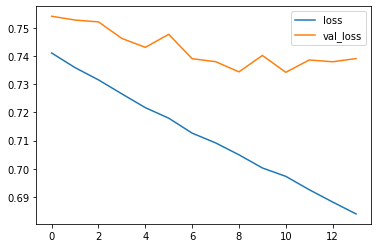

In [112]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

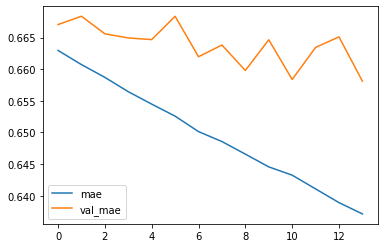

In [113]:
METRIC = "mae"

plt.plot(history.history[f"{METRIC}"])
plt.plot(history.history[f"val_{METRIC}"])
plt.legend([f"{METRIC}",f"val_{METRIC}"])

In [114]:
train.rating.value_counts()

4.0    427005
3.0    239233
5.0    213890
2.0     79582
1.0     40280
Name: rating, dtype: int64

In [115]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

98/98 [==============================] - 1s 9ms/step - loss: 0.6745 - mse: 0.6745 - mae: 0.6286


[0.674545407295227, 0.674545407295227, 0.6286098957061768]

In [116]:
predictions = model.predict([test_user,test_movie])

In [134]:
predictions.astype(int)

array([[3],
       [3],
       [3],
       ...,
       [3],
       [4],
       [4]])

In [153]:
def process_ratings(rating):
    if rating <=1:
        rating = 1.0
    elif rating >=5:
        rating = 5.0
    else:
        rating = np.ceil(rating)
    return rating

In [141]:
y_pred = pd.DataFrame(np.ceil(predictions), columns = ["predictions"])
y_pred["predictions"].apply(lambda rating: process_rating(rating))

In [142]:
y_pred

array([[4.],
       [4.],
       [4.],
       ...,
       [4.],
       [5.],
       [5.]], dtype=float32)

In [143]:
from sklearn.metrics import classification_report, recall_score, ndcg_score, mean_squared_error

In [144]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

        -0.0       0.00      0.00      0.00         0
         1.0       0.93      0.03      0.05      4068
         2.0       0.27      0.04      0.06      7865
         3.0       0.38      0.15      0.21     23901
         4.0       0.45      0.52      0.48     42871
         5.0       0.39      0.73      0.50     21294
         6.0       0.00      0.00      0.00         0

    accuracy                           0.42     99999
   macro avg       0.35      0.21      0.19     99999
weighted avg       0.43      0.42      0.37     99999



c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
import random

In [146]:
def recall_at_n(y_true, y_pred,n=30, threshold=4):
    start_index = random.sample(range(len(y_true)),1)[0]
    end_index = start_index + n
    
    label_window = y_true[start_index:end_index]
    prediction_window = y_pred[start_index:end_index]
    
    relevant_items = np.where(label_window >=threshold)
    recommended_items = np.where(prediction_window >=  threshold)
    return len(np.intersect1d(relevant_items,recommended_items))/len(relevant_items[0])

In [147]:
recall_at_n(y_true=test_y.values, y_pred=y_pred)

0.9545454545454546

In [148]:
test["Prediction"] = y_pred

In [149]:
mean_squared_error(test_y,y_pred)

1.1048110481104811

In [150]:
unique_users = test["user_tags"].unique()


In [151]:
scores = {}

In [152]:
for u in unique_users[:5]:
    test_metric = test[test["user_tags"]==u][["rating","Prediction"]]
    test_metric["actual_relevance"] = test_metric["rating"].apply(lambda x: 1 if x >= 3 else 0)
    test_metric["predicted_relevance"] = test_metric["Prediction"].apply(lambda x: 1 if x >= 3 else 0)
    relevant_items = test_metric[test_metric["actual_relevance"]==1].sort_values(by="rating").index.to_numpy()
    num_of_relevant_top_r_items = len(relevant_items)
    recommended_items = test_metric[test_metric["predicted_relevance"]==1].sort_values(by="Prediction")[:num_of_relevant_top_r_items].index.to_numpy()
    r_precision = len(np.intersect1d(relevant_items,recommended_items))/num_of_relevant_top_r_items
    # recall = len(np.intersect1d(relevant_items,recommended_items))/len(relevant_items)
    # precision = len(np.intersect1d(relevant_items,recommended_items))/len(recommended_items)
    scores[u] = [r_precision]

ZeroDivisionError: division by zero

In [ ]:
print(scores)

{'great ending storytelling kickass original': [0.9661016949152542], 'original great ending storytelling revenge predictable': [0.9035087719298246], 'great performances breakthroughs delights underrated historical disappointments': [0.918444165621079], 'original upton sinclair great ending storytelling white guilt': [0.8709677419354839], 'original great ending storytelling emotional edward norton': [0.9130434782608695]}


In [ ]:
test_metric = test[test["user_tags"]=="great ending storytelling kickass original"][["rating","Prediction"]]

In [ ]:
test_metric

,rating,Prediction,actual_relevance,predicted_relevance
0,1.0,3,0,0
109157,5.0,4,1,1
127411,5.0,4,1,1
156284,5.0,4,1,1
222167,4.0,4,1,1
...,...,...,...,...
1598860,5.0,4,1,1
1622457,4.0,4,1,1
1641816,4.0,4,1,1
1646894,4.0,3,1,0


In [ ]:
test_metric

,rating,Prediction,actual_relevance,predicted_relevance
0,1.0,3,0,0
109157,5.0,4,1,1
127411,5.0,4,1,1
156284,5.0,4,1,1
222167,4.0,4,1,1
...,...,...,...,...
1598860,5.0,4,1,1
1622457,4.0,4,1,1
1641816,4.0,4,1,1
1646894,4.0,3,1,0


In [ ]:
relevant_items

array([ 514648, 1043642, 1346062,  967987,  835368, 1646894,  794624,
        748686,  727540, 1368867,  655650, 1104175,  462154, 1257039,
        411549, 1641816, 1622457,  360806,  335474, 1579906,  279682,
        415901,  262416,  222167,  248445, 1531808, 1304823, 1321921,
       1598860, 1436460, 1511526, 1532917, 1527050, 1356334,  109157,
        797074, 1027887, 1008339,  828802,  714784,  626744,  516338,
        481365,  422403,  386661,  321392,  277460,  156284,  127411,
       1087571, 1650645], dtype=int64)

0.8823529411764706

In [ ]:
evaln.index.tolist()

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
list(zip(y_pred,test_y.values))

[(3, 1.0),
 (4, 4.0),
 (3, 3.0),
 (4, 3.0),
 (4, 4.0),
 (4, 4.0),
 (4, 4.0),
 (3, 3.0),
 (4, 2.0),
 (4, 4.0),
 (3, 3.0),
 (5, 5.0),
 (4, 3.0),
 (4, 4.0),
 (4, 4.0),
 (3, 3.0),
 (4, 4.0),
 (3, 3.0),
 (5, 5.0),
 (3, 3.0),
 (1, 1.0),
 (4, 3.0),
 (4, 4.0),
 (3, 3.0),
 (4, 4.0),
 (4, 5.0),
 (4, 5.0),
 (3, 4.0),
 (4, 3.0),
 (4, 4.0),
 (5, 3.0),
 (3, 4.0),
 (5, 5.0),
 (5, 5.0),
 (4, 4.0),
 (4, 5.0),
 (3, 3.0),
 (2, 3.0),
 (4, 4.0),
 (4, 3.0),
 (4, 4.0),
 (3, 2.0),
 (4, 4.0),
 (4, 4.0),
 (4, 5.0),
 (3, 3.0),
 (5, 5.0),
 (4, 4.0),
 (4, 5.0),
 (2, 2.0),
 (4, 3.0),
 (5, 5.0),
 (4, 5.0),
 (5, 4.0),
 (4, 4.0),
 (4, 3.0),
 (4, 4.0),
 (5, 4.0),
 (5, 5.0),
 (4, 4.0),
 (4, 4.0),
 (4, 3.0),
 (4, 3.0),
 (5, 3.0),
 (3, 3.0),
 (3, 3.0),
 (4, 4.0),
 (3, 3.0),
 (4, 4.0),
 (3, 2.0),
 (4, 3.0),
 (4, 4.0),
 (4, 5.0),
 (5, 5.0),
 (4, 4.0),
 (5, 5.0),
 (4, 5.0),
 (3, 4.0),
 (4, 4.0),
 (5, 5.0),
 (4, 4.0),
 (3, 3.0),
 (3, 1.0),
 (1, 1.0),
 (4, 3.0),
 (4, 4.0),
 (4, 4.0),
 (4, 4.0),
 (4, 4.0),
 (5, 4.0),
 (3, 3.0),

In [ ]:
set(np.where(y_pred>=3)[0])

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 157,
 158,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 1

In [ ]:
/*-

SyntaxError: can't use starred expression here (3310497289.py, line 1)

In [ ]:
def create_user_embedding_generator(classifier):
    user_tag, _ = classifier.inputs
    
    glove_embeddings = classifier.get_layer("embedding")
    user_tag_vectors = glove_embeddings(user_tag)
    # movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    # movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  classifier.get_layer("average")
    
    user_embedding = average_layer(user_tag_vectors)
    # movie_embedding = average_layer(movie_tag_vectors)

    model = Model(inputs = user_tag, outputs = user_embedding)
    
    # optimizer = tf.keras.optimizers.Adam()
    
    # model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
def create_movie_embedding_generator(classifier):
    _ , movie_tag = classifier.inputs
    
    glove_embeddings = classifier.get_layer("embedding")
    # user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    # user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  classifier.get_layer("average")
    
    # user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)

    model = Model(inputs = movie_tag, outputs = movie_embedding)
    
    # optimizer = tf.keras.optimizers.Adam()
    
    # model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
model.load_weights("./models/glove_embeddings_finetuned_model/model_1.0505_acc_0.562.h5")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 embedding (Embedding)          multiple             115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 tf.unstack (TFOpLambda)        [(None, 100),        0           ['embedding[0][0]']          

In [ ]:
user_model = create_user_embedding_generator(model)

In [ ]:
user_input

array([[1012,  690,   10,   69,  167, 1022,    5,  861],
       [1026,  190,  959,  372,  764,   13,   15,   50],
       [ 113,  895,   58,  272,    5,  220, 1047,  398],
       [ 294,  483,  217,    6,  218,   17,  441,  115],
       [   0, 1026,  135,  372,  764,   13,   15,   50]])

In [ ]:
user_meta_data = pd.read_csv("../data/user_metadata.csv")

In [ ]:
movie_meta_data = pd.read_csv("../data/movie_metadata.csv")

In [ ]:
movie_meta_data

,movieId,tag
0,1,Owned|imdb top 250|Pixar|Pixar|time travel|chi...
1,2,Robin Williams|time travel|fantasy|based on ch...
2,3,funny|best friend|duringcreditsstinger|fishing...
3,4,based on novel or book|chick flick|divorce|int...
4,5,aging|baby|confidence|contraception|daughter|g...
...,...,...
45246,208813,might like
45247,208933,black and white|deal with the devil
45248,209035,computer animation|Japan|mass behavior|mass sc...
45249,209037,chameleon|computer animation|gluttony|humorous...


In [ ]:
users = user_meta_data["user_tags"]
movies = movie_meta_data["tag"]

In [ ]:
user_tags = tokenizer.texts_to_sequences(users.tolist())
movie_tags = tokenizer.texts_to_sequences(movies.tolist())

In [ ]:
user_tags = pad_sequences(user_tags,maxlen=8)
movie_tags = pad_sequences(movie_tags, maxlen=16)

In [ ]:
user_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             115600      ['user_tags[0][0]']              
                                                                                                  
 tf.unstack_4 (TFOpLambda)      [(None, 100),        0           ['embedding[4][0]']              
                                 (None, 100),                                                     
                                 (None, 100),                                                     
                                 (None, 100),                                               

In [ ]:
user_input

array([[1012,  690,   10,   69,  167, 1022,    5,  861],
       [1026,  190,  959,  372,  764,   13,   15,   50],
       [ 113,  895,   58,  272,    5,  220, 1047,  398],
       [ 294,  483,  217,    6,  218,   17,  441,  115],
       [   0, 1026,  135,  372,  764,   13,   15,   50]])

In [ ]:
user_embeddings=[]
for u in user_tags:
    # print(np.array([u]).shape)
    embedding = user_model.predict(np.array([u]))
    user_embeddings.append(embedding)

In [ ]:
movie_model = create_movie_embedding_generator(model)

In [ ]:
movie_embeddings=[]
for u in movie_tags:
    # print(np.array([u]).shape)
    embedding = movie_model.predict(np.array([u]))
    movie_embeddings.append(embedding)

In [ ]:
len(user_embeddings)

10825

In [ ]:
np.reshape(np.array(user_embeddings), (10825,100)).shape

(10825, 100)

In [ ]:
user_embedding_df = pd.DataFrame(np.reshape(np.array(user_embeddings), (10825,100)), index=user_meta_data["userId"])
user_embedding_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
userId,,,,,,,,,,,,,,,,,,,,,
3,-0.121341,-0.125917,0.085673,0.038381,0.077507,-0.147435,0.084200,-0.119273,-0.049692,0.092903,...,-0.094062,0.176636,-0.061286,-0.047820,0.015028,-0.107929,0.086117,-0.080702,0.036846,0.118880
4,-0.102689,0.103419,0.010827,0.323775,0.039645,-0.271554,-0.150367,-0.239236,-0.018826,-0.231409,...,-0.048773,-0.190486,-0.329652,0.190306,0.022504,0.148208,-0.241141,-0.325945,0.036916,0.369052
19,-0.023533,-0.317466,-0.084752,-0.033595,-0.004866,-0.175953,-0.062100,-0.123853,0.015007,0.284338,...,0.427892,0.187108,0.181313,-0.320931,0.428260,0.181251,-0.138753,0.059998,0.308398,-0.273252
20,-0.053405,0.011198,-0.006092,0.080694,0.052613,-0.144951,0.062522,0.022935,0.038711,0.015503,...,-0.023501,0.000556,-0.013493,0.035494,0.027715,-0.050210,0.019359,0.057628,0.002154,-0.015680
68,-0.023609,0.007899,-0.058914,0.084986,0.194303,-0.058783,0.102594,-0.006639,-0.021614,0.071474,...,-0.030583,0.006105,-0.037921,0.103596,0.014820,-0.040098,-0.037179,0.012789,0.016486,0.102540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162467,-0.204419,-0.048375,-0.090326,-0.171004,-0.184930,-0.093621,0.079045,0.011678,0.097479,-0.040047,...,0.097885,-0.044462,0.050842,0.066535,0.026851,-0.099415,-0.025332,0.176026,0.145395,-0.193791
162492,0.146008,-0.071524,0.065718,0.047543,0.182813,-0.133984,0.044468,-0.091367,-0.015241,0.042442,...,0.029203,0.317145,-0.148624,-0.037098,0.043106,-0.145035,0.127140,-0.007914,-0.135165,0.106798
162501,-0.013175,-0.243947,0.084938,-0.132431,0.005760,0.179449,-0.166607,0.096545,0.177472,-0.015738,...,-0.014525,-0.133780,-0.023970,-0.028825,0.038200,-0.069904,-0.087183,0.093241,0.018613,-0.089881


In [ ]:
np.array(movie_embeddings).shape

(45251, 1, 100)

In [ ]:
movie_embedding_df = pd.DataFrame(np.reshape(np.array(movie_embeddings), (45251,100)), index=movie_meta_data["movieId"])
movie_embedding_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.593047,0.033794,0.048042,0.134441,0.506332,-0.290345,-0.028565,-0.384276,0.136517,-0.148973,...,0.107009,0.016879,0.516428,-0.091853,-0.159012,-0.362357,0.104021,-0.027608,0.272703,-0.277563
2,0.209889,0.266159,0.256251,-0.090502,-0.197600,0.407033,0.137838,0.205913,-0.057619,-0.180064,...,-0.099201,0.175423,0.438440,-0.385567,-0.274389,-0.264258,0.010146,0.268159,0.371597,-0.371268
3,0.094308,-0.238787,0.026768,-0.062222,0.103212,-0.093965,0.268620,0.229196,0.109590,-0.273120,...,-0.069267,-0.055471,0.076947,0.038989,-0.178510,0.106657,-0.195120,0.102197,-0.122369,-0.096146
4,0.047895,0.077032,-0.354608,-0.255282,-0.257211,0.592242,0.024765,0.028484,0.507291,0.008162,...,-0.042577,0.179383,0.099735,-0.027250,0.244542,-0.214361,0.098254,-0.129777,0.066947,-0.016165
5,0.356860,-0.121125,0.262100,0.045333,-0.288044,0.302943,0.025113,-0.010468,0.158689,-0.098469,...,0.097676,0.173685,0.345943,-0.052000,-0.030655,0.185006,0.069091,0.184781,-0.044920,-0.220905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208813,-0.097420,-0.074152,0.025697,0.019317,-0.034601,-0.044151,-0.051807,0.047489,0.153688,-0.015702,...,-0.015584,-0.081164,-0.012070,-0.102875,0.049942,-0.050385,0.010373,0.170597,-0.005364,-0.077852
208933,-0.135204,0.058925,0.040108,-0.171874,-0.012750,-0.016764,-0.072382,0.034830,0.067799,-0.002493,...,-0.050237,-0.325632,-0.069068,-0.055653,-0.174641,-0.193955,-0.332542,0.109513,0.062132,-0.175021
209035,-0.099222,0.021947,0.042990,0.096232,0.007968,-0.094830,-0.106738,-0.019215,0.051752,0.037721,...,0.214699,-0.060750,0.100028,-0.165911,0.253974,-0.181411,-0.020588,0.134096,0.082989,-0.185959


In [ ]:
user_embedding_df.to_csv("../output/user_embeddings.csv")
movie_embedding_df.to_csv("../output/movie_embeddings.csv")